In [470]:
import sys
import data
import data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


In [471]:
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/')

Converting one-hot labels to integers


In [3]:
class Object(object):
    pass
opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue

In [474]:
tcgatissue.set_graph(opt)
len(tcgatissue.df)
# plt.imshow(tcgatissue.adj)

'Graph' object has no attribute 'labels'


10459

In [5]:
g = nx.from_numpy_matrix(tcgatissue.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [383]:
def lr(df, labels, trials, samples):
    scores = []
    for i in range(trials):
        X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(df[:samples], labels[:samples], stratify=labels[:samples], train_size=0.1, random_state=i)

        model = sklearn.linear_model.LogisticRegression()
        model = model.fit(X_train, y_train)

        score = sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))
        scores.append(score)
    return np.round(np.mean(scores), 2),  np.round(np.std(scores),2)


def mlp(df, labels, trials, samples):
    # Try with only 1 layer, and with regularization
    scores = []
    for i in range(trials):
        X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(df[:samples], labels[:samples], stratify=labels[:samples], train_size=0.1, random_state=i)
        
        model = sklearn.neural_network.MLPClassifier()
        model = model.fit(X_train, y_train)

        score = sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))
        scores.append(score)
    return np.round(np.mean(scores), 2),  np.round(np.std(scores),2)

def decision_tree(df, labels, trials, samples):
    scores = []
    for i in range(trials):
        X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(df[:samples], labels[:samples], stratify=labels[:samples], train_size=0.1, random_state=i)
        
        model = sklearn.tree.DecisionTreeClassifier()
        model = model.fit(X_train, y_train)

        score = sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))
        scores.append(score)
    return np.round(np.mean(scores), 2),  np.round(np.std(scores),2)



In [301]:
genes_with_neighbors = [x for x in g.nodes() if len(list(g.neighbors(x)))>1]

In [32]:
def get_second_degree(gene, g):
    l = list(g.neighbors(gene))
    neighbors = l[:]
    for index, gene in enumerate(l):
        neighbors.extend(list(g.neighbors(gene)))
    return neighbors


In [391]:
sklearn.tree.DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [405]:
all_genes = pd.DataFrame(columns=["gene_name",
                                  "full_lr_auc",
                                  "full_lr_std",
                                  "first_degree_lr_auc",
                                  "first_degree_lr_std", 
                                  "second_degree_lr_auc",
                                  "second_degree_lr_std",
                                  "first_degree_lr_diff",
                                  "second_degree_lr_diff",
                                  "full_mlp_auc",
                                  "full_mlp_std",
                                  "first_degree_mlp_auc",
                                  "first_degree_mlp_std", 
                                  "second_degree_mlp_auc",
                                  "second_degree_mlp_std",
                                  "first_degree_mlp_diff",
                                  "second_degree_mlp_diff",
                                  "first_degree_neighbors",
                                  "second_degree_neighbors"])
print "Genes to do:" + str(len(genes_with_neighbors))
sys.stdout.write("Trial number:")

for index, gene in enumerate(genes_with_neighbors):
    df = tcgatissue.df
    labels = [1 if x > df[gene].mean() else 0 for x in df[gene]]
    df = df.drop(gene, axis=1)

    first_degree_neighbors = df.loc[:, list(g.neighbors(gene))].dropna(axis=1)
    second_degree_neighbors = df.loc[:, list(get_second_degree(gene, g))].dropna(axis=1)
  
    # lr
    full_lr = lr(df, labels, 10, 1000)
    first_degree_lr = lr(first_degree_neighbors, labels, 10, 1000)
    second_degree_lr = lr(second_degree_neighbors, labels, 10, 1000)
    first_degree_diff_lr = full_lr[0] - first_degree_lr[0]
    second_degree_diff_lr = full_lr[0] - second_degree_lr[0]

    # mlp
    full_mlp = mlp(df, labels, 10, 1000)
    first_degree_mlp = mlp(first_degree_neighbors, labels, 10, 1000)
    second_degree_mlp = mlp(second_degree_neighbors, labels, 10, 1000)
    first_degree_diff_mlp = full_mlp[0] - first_degree_mlp[0]
    second_degree_diff_mlp = full_mlp[0] - second_degree_mlp[0]

    # CGN
    
    # Decision Tree
    full_dt = decision_tree(df, labels, 10, 1000)
    first_degree_dt = decision_tree(first_degree_neighbors, labels, 10, 1000)
    second_degree_dt = decision_tree(second_degree_neighbors, labels, 10, 1000)
    first_degree_diff_dt = full_dt[0] - first_degree_dt[0]
    second_degree_diff_dt = full_dt[0] - second_degree_dt[0]

    data = {"gene_name": gene,
            "full_lr_auc": full_lr[0],
            "full_lr_std": full_lr[1], 
            "first_degree_lr_auc": first_degree_lr[0],
            "first_degree_lr_std": first_degree_lr[1],
            "first_degree_lr_diff": first_degree_diff_lr,
            "second_degree_lr_diff": second_degree_diff_lr,
            "second_degree_lr_auc": second_degree_lr[0],
            "second_degree_lr_std": second_degree_lr[1],
            "full_mlp_auc": full_mlp[0],
            "full_mlp_std": full_mlp[1], 
            "first_degree_mlp_auc": first_degree_mlp[0],
            "first_degree_mlp_std": first_degree_mlp[1],
            "first_degree_mlp_diff": first_degree_diff_mlp,
            "second_degree_mlp_diff": second_degree_diff_mlp,
            "second_degree_mlp_auc": second_degree_mlp[0],
            "second_degree_mlp_std": second_degree_mlp[1],
            "full_dt_auc": full_dt[0],
            "full_dt_std": full_dt[1], 
            "first_degree_dt_auc": first_degree_dt[0],
            "first_degree_dt_std": first_degree_dt[1],
            "first_degree_dt_diff": first_degree_diff_dt,
            "second_degree_dt_diff": second_degree_diff_dt,
            "second_degree_dt_auc": second_degree_dt[0],
            "second_degree_dt_std": second_degree_dt[1],
            "first_degree_neighbors": ','.join(first_degree_neighbors.columns.tolist()),
            "second_degree_neighbors": ','.join(second_degree_neighbors.columns.tolist())
           }
    all_genes = all_genes.append(pd.DataFrame(data, index=[0]))
    #print all_genes
    sys.stdout.write(str(index) + ", ")
all_genes.to_csv('all_genes.csv')


Genes to do:677
Trial number:

/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [375]:
all_genes

,first_degree_dt_auc,first_degree_dt_diff,first_degree_dt_std,first_degree_lr_auc,first_degree_lr_diff,first_degree_lr_std,first_degree_mlp_auc,first_degree_mlp_diff,first_degree_mlp_std,first_degree_neighbors,...,second_degree_dt_auc,second_degree_dt_diff,second_degree_dt_std,second_degree_lr_auc,second_degree_lr_diff,second_degree_lr_std,second_degree_mlp_auc,second_degree_mlp_diff,second_degree_mlp_std,second_degree_neighbors
0,0.58,-0.05,0.06,0.43,0.12,0.05,0.50,0.00,0.00,"UBE2I,UBE2D4",...,0.53,0.00,0.06,0.58,-0.03,0.06,0.50,0.00,0.02,"UBE2I,UBE2D4,NUDCD3,HDAC3,HSF2,ATF7IP,MKRN3,RI..."
0,0.58,-0.01,0.07,0.64,0.03,0.07,0.52,-0.02,0.04,"STAB1,HSPA5,UPF2,MYO1C,HSP90B1,FYCO1,TRIM21,RI...",...,0.55,0.02,0.06,0.69,-0.02,0.05,0.50,0.00,0.00,"STAB1,HSPA5,UPF2,MYO1C,HSP90B1,FYCO1,TRIM21,RI..."
0,0.63,0.00,0.08,0.66,-0.06,0.05,0.50,0.00,0.02,"ACADVL,HSPA6,PCSK7,ANP32B,NDRG1,SQRDL,MSR1,SGP...",...,0.64,-0.01,0.05,0.61,-0.01,0.05,0.51,-0.01,0.02,"ACADVL,HSPA6,PCSK7,ANP32B,NDRG1,SQRDL,MSR1,SGP..."
0,0.55,0.27,0.06,0.53,0.32,0.04,0.52,0.00,0.05,"HEYL,TNFAIP3",...,0.63,0.19,0.06,0.65,0.20,0.06,0.57,-0.05,0.11,"HEYL,TNFAIP3,SMAD9,SMAD7,ATF7IP,SKIL,HAND1,TRA..."


In [341]:
all_genes.columns

Index([u'first_degree_dt_auc', u'first_degree_dt_diff', u'first_degree_dt_std',
       u'first_degree_lr_auc', u'first_degree_lr_diff', u'first_degree_lr_std',
       u'first_degree_mlp_auc', u'first_degree_mlp_diff',
       u'first_degree_mlp_std', u'first_degree_neighbors', u'full_dt_auc',
       u'full_dt_std', u'full_lr_auc', u'full_lr_std', u'full_mlp_auc',
       u'full_mlp_std', u'gene_name', u'second_degree_dt_auc',
       u'second_degree_dt_diff', u'second_degree_dt_std',
       u'second_degree_lr_auc', u'second_degree_lr_diff',
       u'second_degree_lr_std', u'second_degree_mlp_auc',
       u'second_degree_mlp_diff', u'second_degree_mlp_std',
       u'second_degree_neighbors'],
      dtype='object')

In [438]:
lr_df = all_genes.loc[all_genes.loc[:, 'first_degree_lr_diff'] < -0.05]
lr_df = lr_df.sort_values(['first_degree_lr_diff'])
lr_df = lr_df.reset_index()

mlp_df = all_genes.loc[all_genes.loc[:, 'first_degree_mlp_auc'] - all_genes.loc[:, 'full_mlp_auc'] > 0.05]
mlp_df = mlp_df.sort_values(['first_degree_mlp_diff'])
mlp_df = mlp_df.reset_index()


dt_df = all_genes.loc[all_genes.loc[:, 'first_degree_dt_auc'] - all_genes.loc[:, 'full_dt_auc'] > 0.05]
dt_df = dt_df.sort_values(['first_degree_dt_diff'])
dt_df = dt_df.reset_index()


In [442]:
# dt_df.loc[:, ['first_degree_dt_auc','full_dt_auc']]
mlp_df

,index,first_degree_dt_auc,first_degree_dt_diff,first_degree_dt_std,first_degree_lr_auc,first_degree_lr_diff,first_degree_lr_std,first_degree_mlp_auc,first_degree_mlp_diff,first_degree_mlp_std,...,second_degree_dt_auc,second_degree_dt_diff,second_degree_dt_std,second_degree_lr_auc,second_degree_lr_diff,second_degree_lr_std,second_degree_mlp_auc,second_degree_mlp_diff,second_degree_mlp_std,second_degree_neighbors
0,0,0.86,-0.01,0.02,0.86,-0.03,0.01,0.75,-0.24,0.13,...,0.86,-0.01,0.02,0.89,-0.06,0.01,0.63,-0.12,0.18,"LY96,MYD88,S100A8,TAGLN,RIPK1,MYD88,TLR2,CD14,..."
1,0,0.86,-0.01,0.02,0.88,-0.06,0.01,0.71,-0.21,0.17,...,0.86,-0.01,0.03,0.87,-0.05,0.02,0.61,-0.11,0.15,"LY96,NCF2,MYD88,S100A9,RIPK1,MYD88,TLR2,CD14,T..."
2,0,0.61,0.09,0.01,0.66,0.16,0.01,0.65,-0.15,0.03,...,0.72,-0.02,0.02,0.75,0.07,0.02,0.61,-0.11,0.09,"KRT1,CSTA,ACADVL,HSPA5,AMPD3,ITGA2,SERPING1,AN..."
3,0,0.61,0.05,0.02,0.65,0.06,0.01,0.65,-0.15,0.01,...,0.64,0.02,0.02,0.68,0.03,0.02,0.56,-0.06,0.09,"AP4M1,GRIA1,AP4E1,CD63,LAMP2,HOMER1,CAMK2A,GRI..."
4,0,0.61,0.04,0.01,0.64,0.11,0.01,0.64,-0.14,0.01,...,0.62,0.03,0.03,0.67,0.08,0.02,0.56,-0.06,0.07,"HOMER1,GRID2,CAMK2A,GRIA4,EPB41,EFNB2,GRIK1,IT..."
5,0,0.60,0.08,0.04,0.67,0.10,0.01,0.63,-0.13,0.07,...,0.65,0.03,0.03,0.67,0.10,0.01,0.52,-0.02,0.05,"CASP5,CASP1,CASP1,CASP4,CASP5,CASP3,PSEN2,LMNA..."
6,0,0.85,-0.04,0.02,0.83,0.03,0.00,0.64,-0.13,0.16,...,0.85,-0.04,0.03,0.83,0.03,0.01,0.55,-0.04,0.12,"COL5A2,SPARC,PDGFA,SDC2,PLAT"
7,0,0.76,0.01,0.03,0.80,0.01,0.01,0.61,-0.11,0.14,...,0.76,0.01,0.04,0.80,0.01,0.02,0.57,-0.07,0.11,"HRAS,IL6ST,CD4,PLCG2,PTK2B,SH3BP2,CRK,EED,ZYX,..."
8,0,0.57,0.13,0.04,0.64,0.15,0.01,0.60,-0.10,0.05,...,0.62,0.08,0.02,0.63,0.16,0.02,0.52,-0.02,0.06,"ITPR1,ATP2A1,CALM1,SDC2,HOMER1,LYN,GRM1,TNFRSF1B"
9,0,0.80,0.03,0.02,0.83,0.02,0.01,0.60,-0.10,0.17,...,0.80,0.03,0.03,0.84,0.01,0.03,0.60,-0.10,0.16,"CSF2RB,ITGB2,STAT3,SKAP2,PLAUR,ABI1,VAV1,CBL,F..."


0.7505169867060562
0.6629394387001477
0.5052732644017726


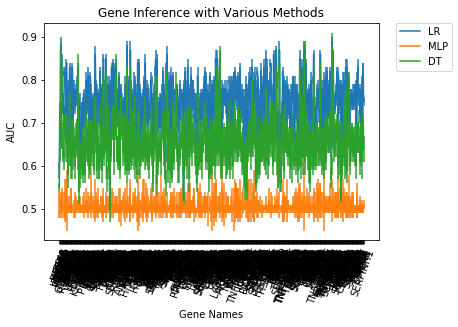

In [460]:
# AUC
plt.figure()
test = all_genes.loc[:, ['gene_name', 'full_dt_auc', 'full_mlp_auc', 'full_lr_auc', 'full_lr_std', 'full_dt_std', 'full_mlp_std']]
test = test.reset_index()

line1 = plt.errorbar(test.index, test['full_lr_auc'], xerr=0, yerr=test['full_lr_std'])
line2 = plt.errorbar(test.index, test['full_mlp_auc'], xerr=0, yerr=test['full_mlp_std'])
line3 = plt.errorbar(test.index, test['full_dt_auc'], xerr=0, yerr=test['full_dt_std'])

width = 0.2
plt.xticks(test.index, test['gene_name'], rotation=70)
plt.title("Gene Inference with Various Methods")
plt.ylabel("AUC")
plt.xlabel("Gene Names")

# Legend
plt.legend((line1[0], line2[0], line3[0]), ('LR', 'MLP', 'DT'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
print test['full_lr_auc'].mean()
print test['full_dt_auc'].mean()
print test['full_mlp_auc'].mean()

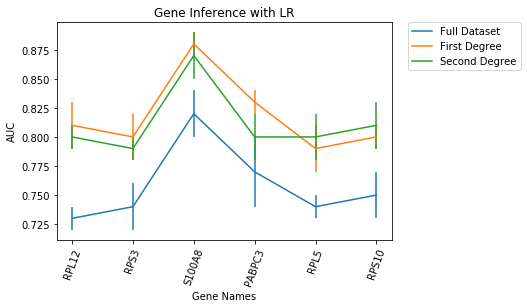

In [447]:
# LR 
plt.figure()
line1 = plt.errorbar(lr_df.index, lr_df['full_lr_auc'], xerr=0, yerr=lr_df['full_lr_std'])
line2 = plt.errorbar(lr_df.index, lr_df['first_degree_lr_auc'], xerr=0, yerr=lr_df['first_degree_lr_std'])
line3 = plt.errorbar(lr_df.index, lr_df['second_degree_lr_auc'], xerr=0, yerr=lr_df['second_degree_lr_std'])

width = 0.2
plt.xticks(lr_df.index, lr_df['gene_name'], rotation=70)
plt.title("Gene Inference with LR")
plt.ylabel("AUC")
plt.xlabel("Gene Names")

# Legend
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
#lr_df

,index,first_degree_dt_auc,first_degree_dt_diff,first_degree_dt_std,first_degree_lr_auc,first_degree_lr_diff,first_degree_lr_std,first_degree_mlp_auc,first_degree_mlp_diff,first_degree_mlp_std,...,second_degree_dt_auc,second_degree_dt_diff,second_degree_dt_std,second_degree_lr_auc,second_degree_lr_diff,second_degree_lr_std,second_degree_mlp_auc,second_degree_mlp_diff,second_degree_mlp_std,second_degree_neighbors
0,0,0.86,-0.01,0.02,0.86,-0.03,0.01,0.75,-0.24,0.13,...,0.86,-0.01,0.02,0.89,-0.06,0.01,0.63,-0.12,0.18,"LY96,MYD88,S100A8,TAGLN,RIPK1,MYD88,TLR2,CD14,..."
1,0,0.86,-0.01,0.02,0.88,-0.06,0.01,0.71,-0.21,0.17,...,0.86,-0.01,0.03,0.87,-0.05,0.02,0.61,-0.11,0.15,"LY96,NCF2,MYD88,S100A9,RIPK1,MYD88,TLR2,CD14,T..."
2,0,0.61,0.09,0.01,0.66,0.16,0.01,0.65,-0.15,0.03,...,0.72,-0.02,0.02,0.75,0.07,0.02,0.61,-0.11,0.09,"KRT1,CSTA,ACADVL,HSPA5,AMPD3,ITGA2,SERPING1,AN..."
3,0,0.61,0.05,0.02,0.65,0.06,0.01,0.65,-0.15,0.01,...,0.64,0.02,0.02,0.68,0.03,0.02,0.56,-0.06,0.09,"AP4M1,GRIA1,AP4E1,CD63,LAMP2,HOMER1,CAMK2A,GRI..."
4,0,0.61,0.04,0.01,0.64,0.11,0.01,0.64,-0.14,0.01,...,0.62,0.03,0.03,0.67,0.08,0.02,0.56,-0.06,0.07,"HOMER1,GRID2,CAMK2A,GRIA4,EPB41,EFNB2,GRIK1,IT..."
5,0,0.60,0.08,0.04,0.67,0.10,0.01,0.63,-0.13,0.07,...,0.65,0.03,0.03,0.67,0.10,0.01,0.52,-0.02,0.05,"CASP5,CASP1,CASP1,CASP4,CASP5,CASP3,PSEN2,LMNA..."
6,0,0.85,-0.04,0.02,0.83,0.03,0.00,0.64,-0.13,0.16,...,0.85,-0.04,0.03,0.83,0.03,0.01,0.55,-0.04,0.12,"COL5A2,SPARC,PDGFA,SDC2,PLAT"
7,0,0.76,0.01,0.03,0.80,0.01,0.01,0.61,-0.11,0.14,...,0.76,0.01,0.04,0.80,0.01,0.02,0.57,-0.07,0.11,"HRAS,IL6ST,CD4,PLCG2,PTK2B,SH3BP2,CRK,EED,ZYX,..."
8,0,0.57,0.13,0.04,0.64,0.15,0.01,0.60,-0.10,0.05,...,0.62,0.08,0.02,0.63,0.16,0.02,0.52,-0.02,0.06,"ITPR1,ATP2A1,CALM1,SDC2,HOMER1,LYN,GRM1,TNFRSF1B"
9,0,0.80,0.03,0.02,0.83,0.02,0.01,0.60,-0.10,0.17,...,0.80,0.03,0.03,0.84,0.01,0.03,0.60,-0.10,0.16,"CSF2RB,ITGB2,STAT3,SKAP2,PLAUR,ABI1,VAV1,CBL,F..."


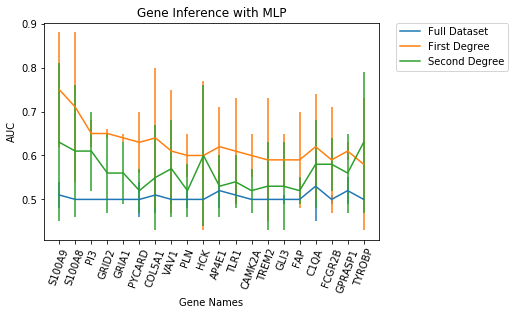

In [449]:
#mlp
mlp_df = mlp_df[0:20]
plt.figure()
line1 = plt.errorbar(mlp_df.index, mlp_df['full_mlp_auc'], xerr=0, yerr=mlp_df['full_mlp_std'])
line2 = plt.errorbar(mlp_df.index, mlp_df['first_degree_mlp_auc'], xerr=0, yerr=mlp_df['first_degree_mlp_std'])
line3 = plt.errorbar(mlp_df.index, mlp_df['second_degree_mlp_auc'], xerr=0, yerr=mlp_df['second_degree_mlp_std'])

width = 0.2
plt.xticks(mlp_df.index, mlp_df['gene_name'], rotation=70)
plt.title("Gene Inference with MLP")
plt.ylabel("AUC")
plt.xlabel("Gene Names")

# Legend
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
mlp_df

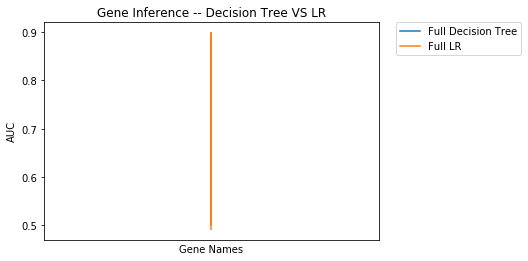

In [476]:
# Decision Tree
#df1 = all_genes[all_genes.loc[:, 'full_dt_auc'] - all_genes.loc[:, 'second_degree_dt_auc'] < -0.05]
df1 = all_genes
plt.figure()

line1 = plt.errorbar(dt_df_reduced.index, dt_df_reduced['full_dt_auc'], xerr=0, yerr=dt_df_reduced['full_dt_std'])
#line3 = plt.errorbar(dt_df_reduced.index, dt_df_reduced['second_degree_dt_auc'], xerr=0, yerr=dt_df_reduced['second_degree_dt_std'])
line2 = plt.errorbar(all_genes.index, all_genes['full_lr_auc'], xerr=0, yerr=all_genes['full_lr_std'])
width = 0.2
plt.xticks(dt_df_reduced.index, dt_df_reduced['gene_name'], rotation=70)
plt.title("Gene Inference -- Decision Tree VS LR")
plt.ylabel("AUC")
plt.xlabel("Gene Names")

# Legend
plt.legend((line1[0], line2[0]), ('Full Decision Tree', 'Full LR'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
#(all_genes.loc[:, 'full_dt_auc']- all_genes.loc[:, 'first_degree_dt_auc']).sort_values()

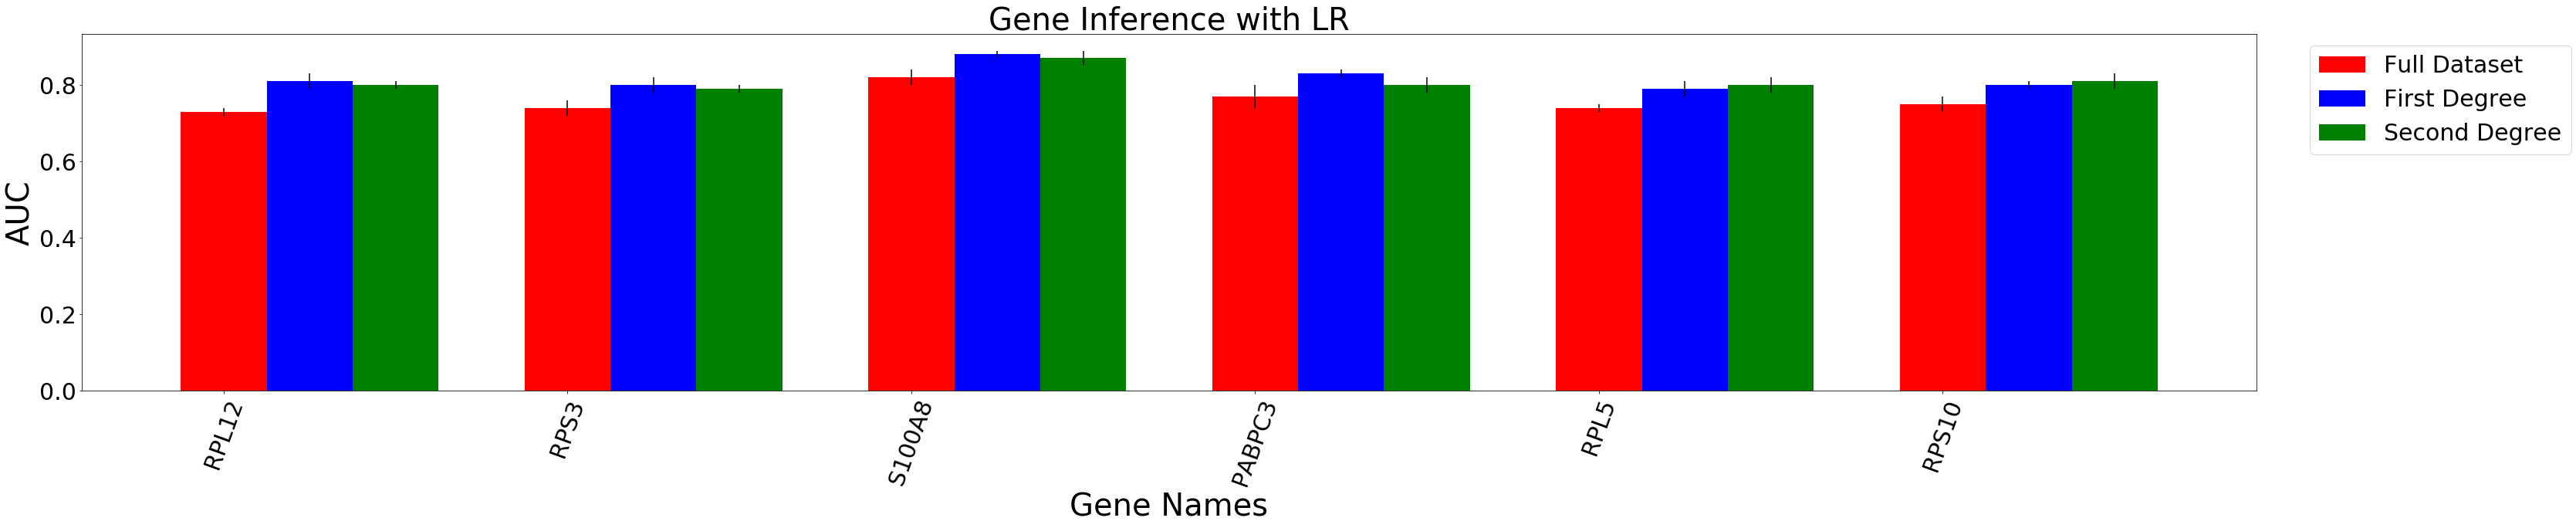

In [453]:
# Bar Chart (LR)
plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(50.5, 8.5)

width = 0.25
rects1 = ax.bar(lr_df.index, lr_df['full_lr_auc'], width=width, color='r', yerr=lr_df['full_lr_std'])
rects2 = ax.bar(lr_df.index + width, lr_df['first_degree_lr_auc'], width=width, color='b', yerr=lr_df['first_degree_lr_std'])
rects3 = ax.bar(lr_df.index + 2*width, lr_df['second_degree_lr_auc'], width=width, color='g', yerr=lr_df['second_degree_lr_std'])

# Labels
plt.xticks(lr_df.index, lr_df['gene_name'], rotation=70, fontsize=60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.title("Gene Inference with LR",fontsize=40)
plt.ylabel("AUC", fontsize=40)
plt.xlabel("Gene Names",fontsize=40)

# Legend
leg = ax.legend((rects1[0], rects2[0], rects3[0]), ('Full Dataset', 'First Degree', 'Second Degree'))
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = .15
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

params = {'legend.fontsize': 30}
plt.rcParams.update(params)


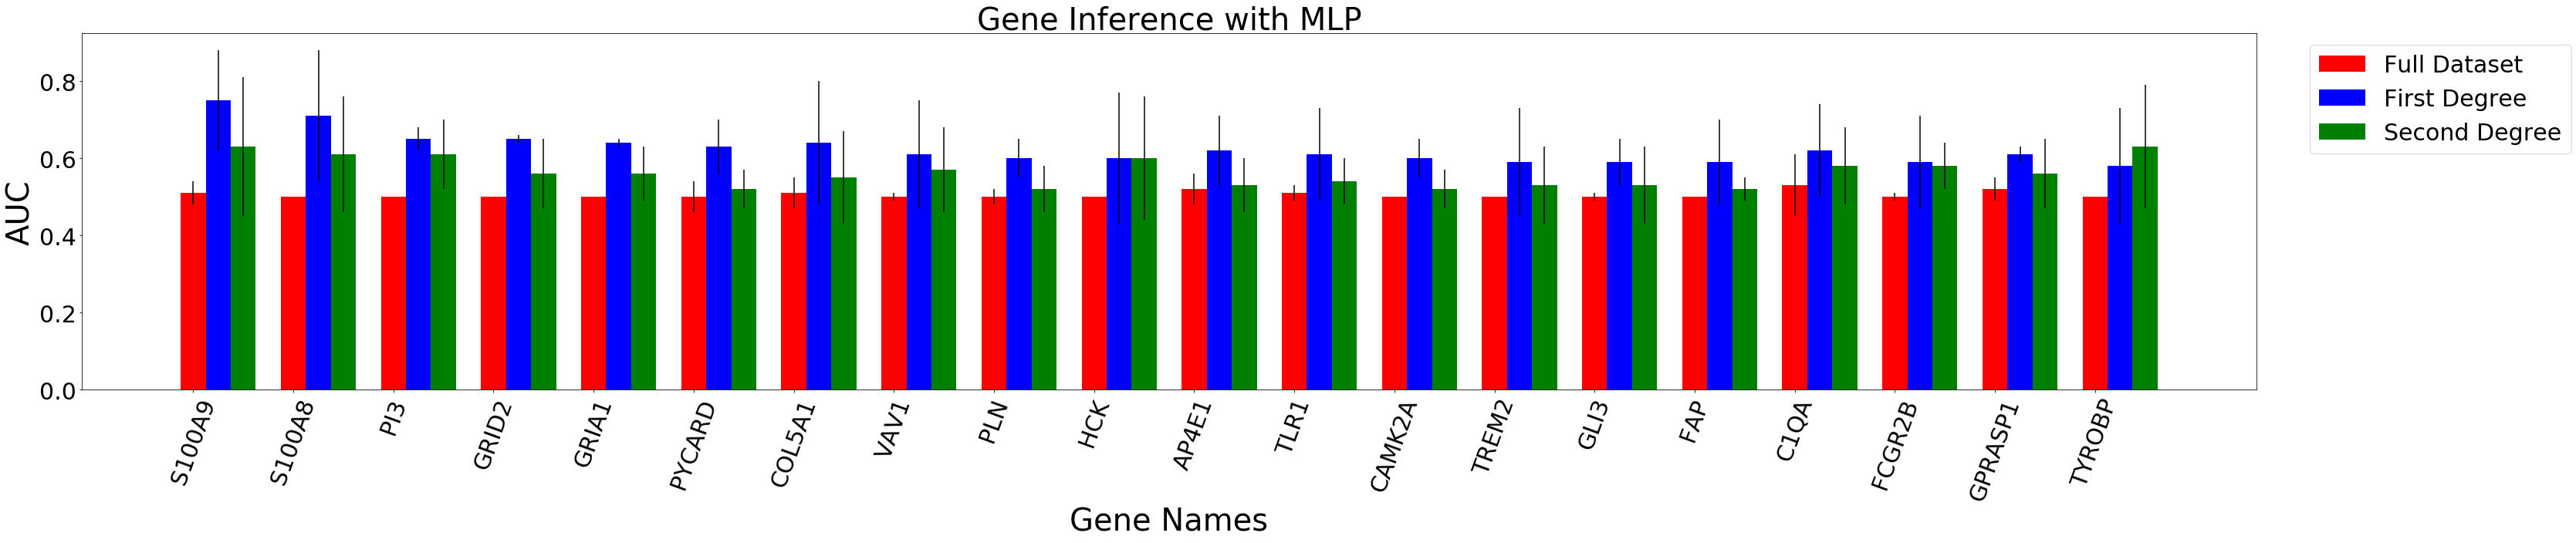

In [454]:
# Bar Chart ( MLP )
plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(50.5, 8.5)

width = 0.25
rects1 = ax.bar(mlp_df.index, mlp_df['full_mlp_auc'], width=width, color='r', yerr=mlp_df['full_mlp_std'])
rects2 = ax.bar(mlp_df.index + width, mlp_df['first_degree_mlp_auc'], width=width, color='b', yerr=mlp_df['first_degree_mlp_std'])
rects3 = ax.bar(mlp_df.index + 2*width, mlp_df['second_degree_mlp_auc'], width=width, color='g', yerr=mlp_df['second_degree_mlp_std'])

# Labels
plt.xticks(mlp_df.index, mlp_df['gene_name'], rotation=70, fontsize=60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.title("Gene Inference with MLP",fontsize=40)
plt.ylabel("AUC", fontsize=40)
plt.xlabel("Gene Names",fontsize=40)

# Legend
leg = ax.legend((rects1[0], rects2[0], rects3[0]), ('Full Dataset', 'First Degree', 'Second Degree'))
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = .15
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

params = {'legend.fontsize': 30}
plt.rcParams.update(params)


In [ ]:
# Graphical Character example

In [455]:
# 1st degree
first_degree_neighbors = g.neighbors("RPL5")
first_degree_neighbor_subgraph = g.subgraph(first_degree_neighbors)


'num nodes:29'

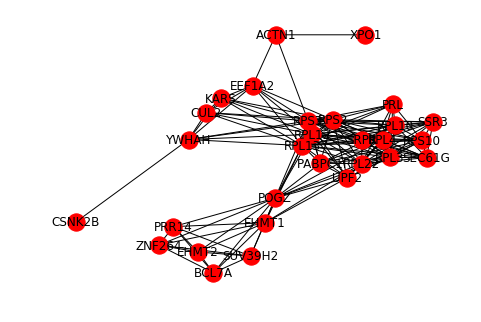

In [456]:
pos = nx.spring_layout(first_degree_neighbor_subgraph, k=1.45,iterations=100)
nx.draw(first_degree_neighbor_subgraph, pos=pos, with_labels=True)
"num nodes:" + str(len([x for x  in g.neighbors("RPL5")]))

In [299]:
# 2nd degree
second_degree_neighborhood = []
for n in g.neighbors("RPL5"):
    second_degree_neighborhood.extend(g.neighbors(n))
second_degree_subgraph = g.subgraph(second_degree_neighborhood)

'num nodes:1147'

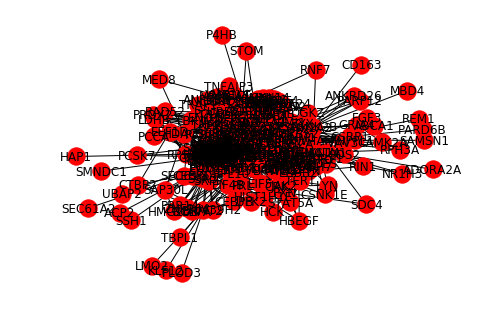

In [300]:
pos = nx.spring_layout(second_degree_subgraph, k=.25,iterations=100)
nx.draw(second_degree_subgraph, pos=pos, with_labels=True)
"num nodes:" + str(len(second_degree_neighborhood))

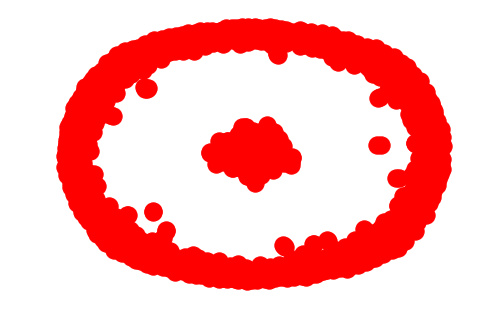

In [461]:
nx.draw(g)

In [462]:
len(g.nodes())

1768